In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import time
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.metrics import confusion_matrix 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn import tree
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import CategoricalNB

In [2]:
!wget https://www.cmi.ac.in/~madhavan/courses/dmml2021apr/assignment1/bank-data.zip
!unzip bank-data.zip

--2021-09-26 09:06:45--  https://www.cmi.ac.in/~madhavan/courses/dmml2021apr/assignment1/bank-data.zip
Resolving www.cmi.ac.in (www.cmi.ac.in)... 115.248.21.185, 123.63.203.217
Connecting to www.cmi.ac.in (www.cmi.ac.in)|115.248.21.185|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 383335 (374K) [application/zip]
Saving to: ‘bank-data.zip’

bank-data.zip       100%[===================>] 374.35K   387KB/s    in 1.0s    

2021-09-26 09:06:47 (387 KB/s) - ‘bank-data.zip’ saved [383335/383335]

Archive:  bank-data.zip
  inflating: bank-data/bank-additional-full.csv  
  inflating: bank-data/bank-additional-names.txt  


In [3]:
data = pd.read_csv("bank-data/bank-additional-full.csv",sep=";")

In [4]:
categorical_columns= [col for col in data.columns if data[col].dtype=="O"]
numeric_columns= [col for col in data.columns if data[col].dtype!="O"]

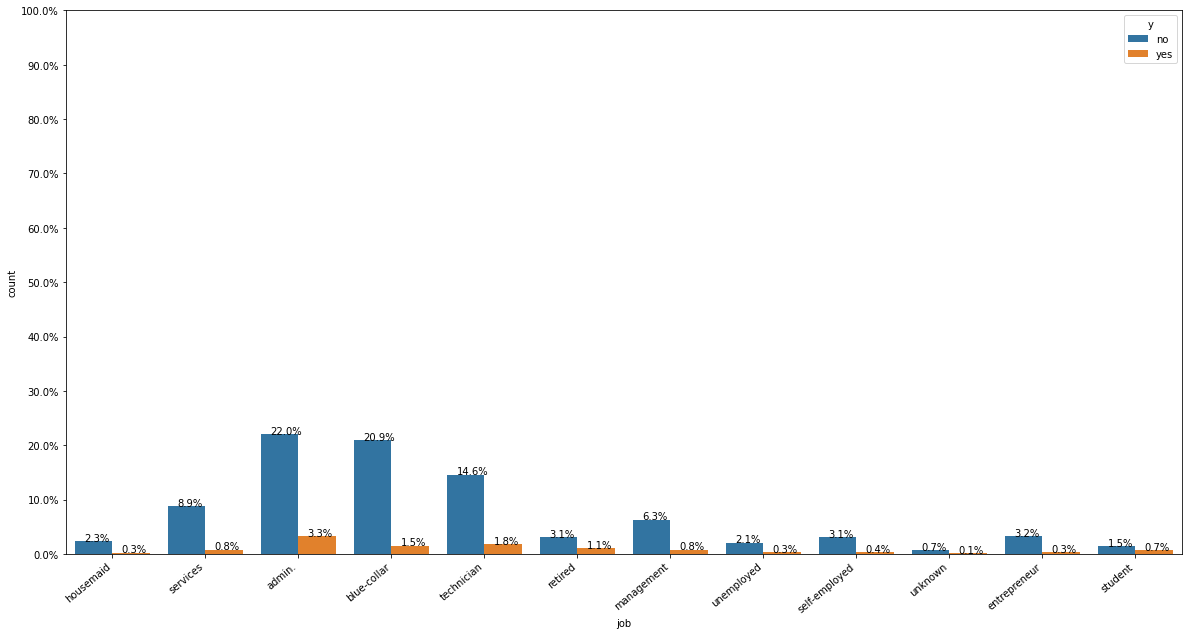

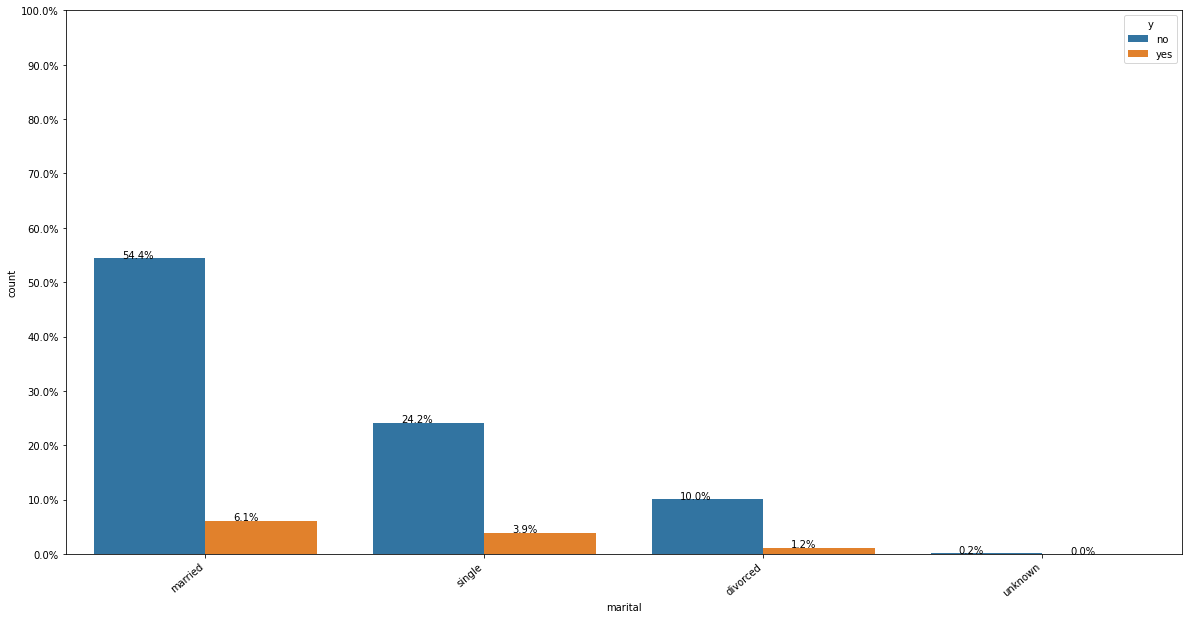

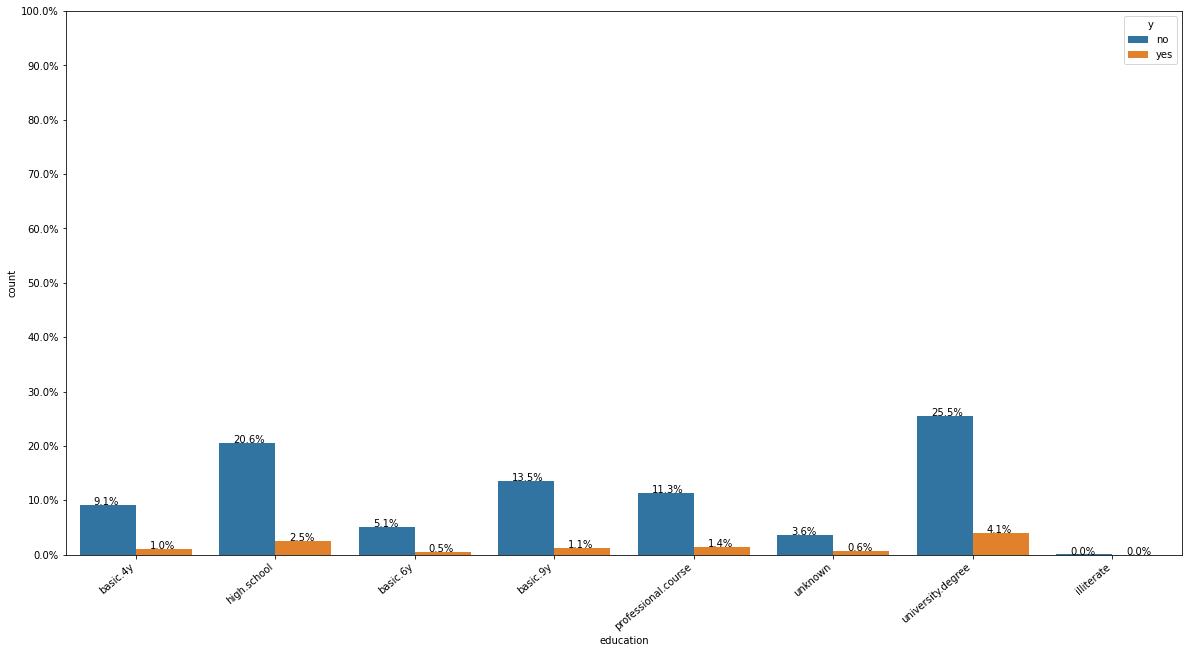

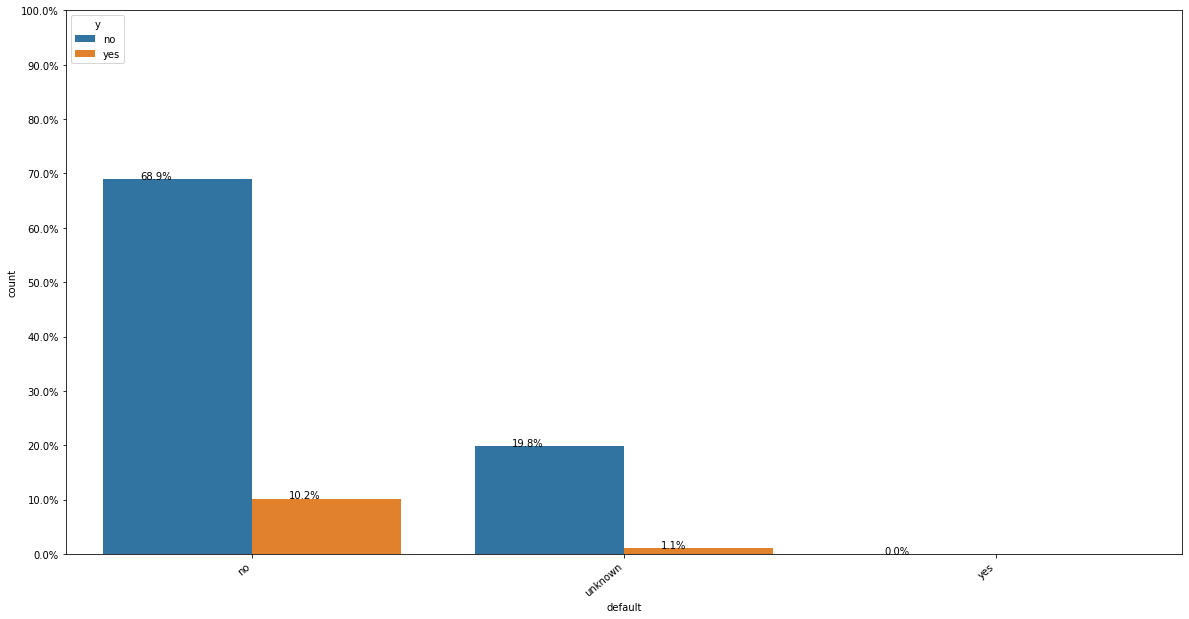

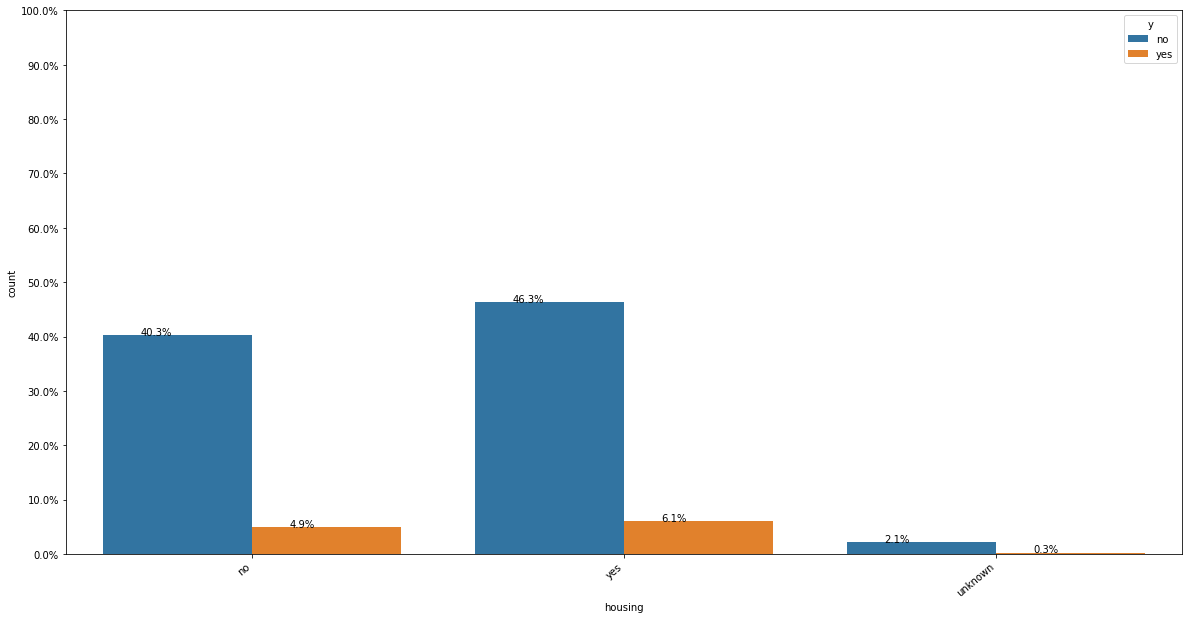

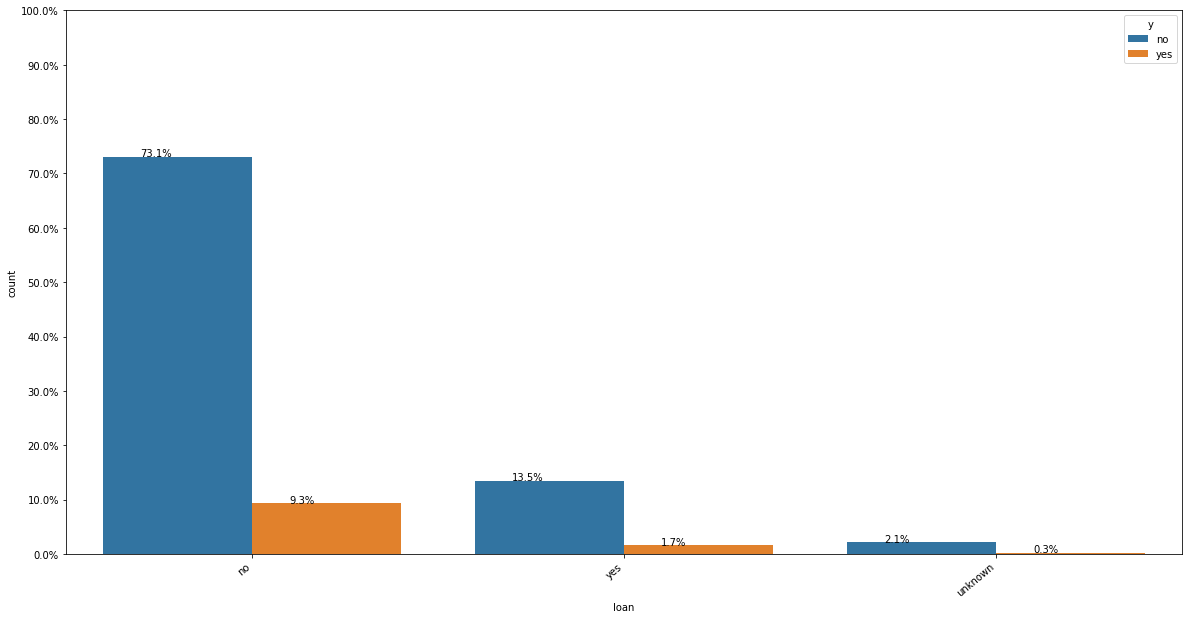

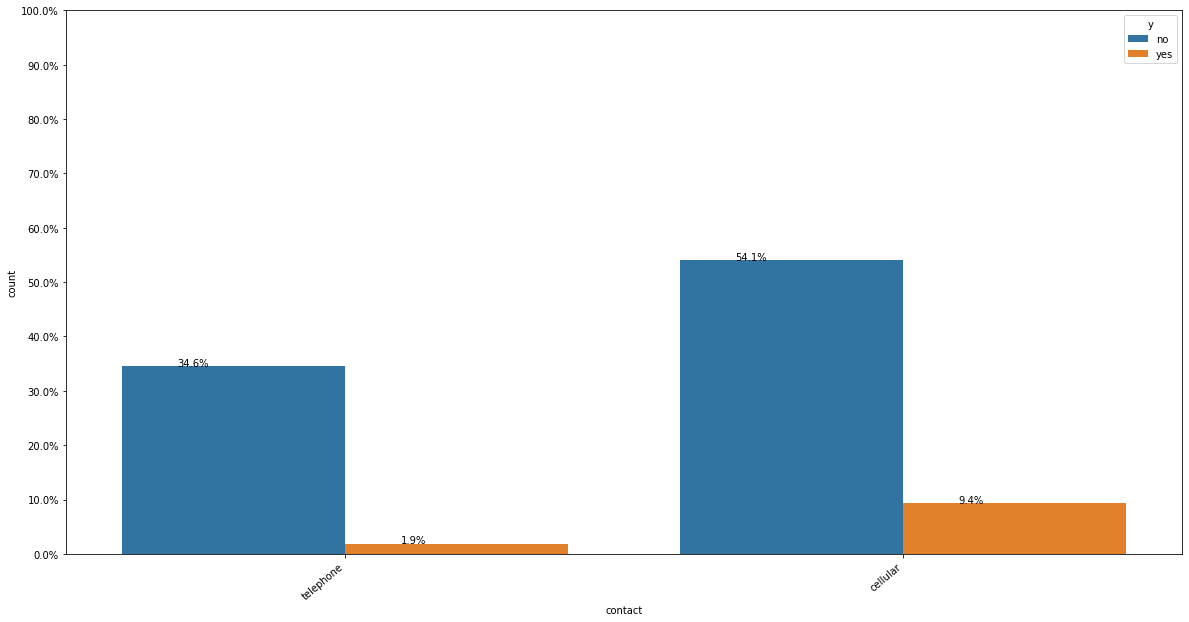

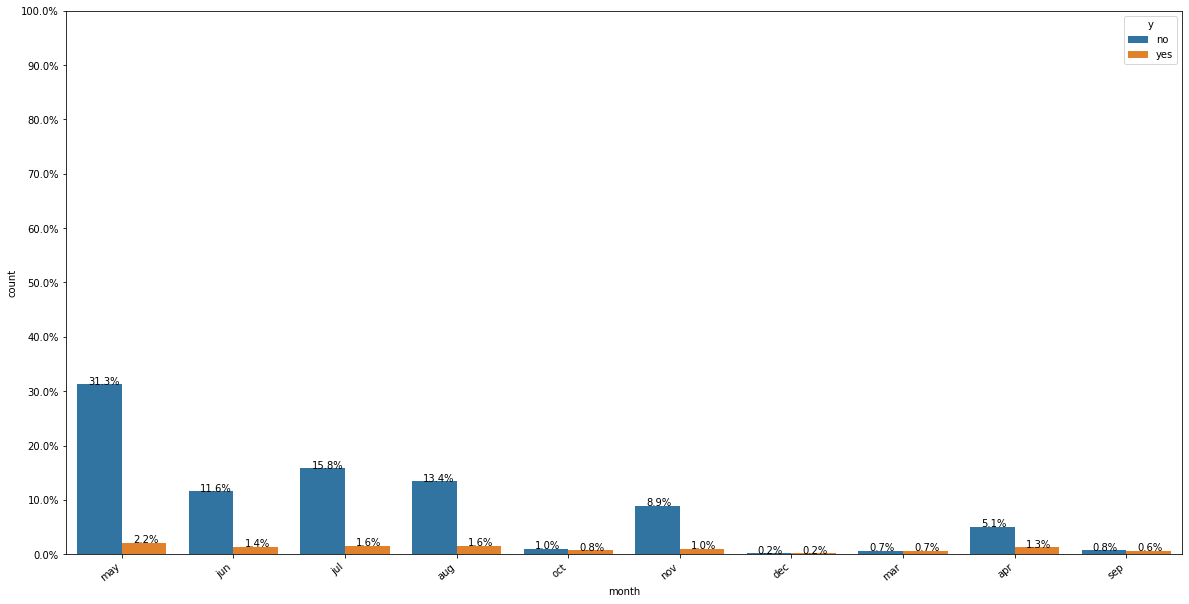

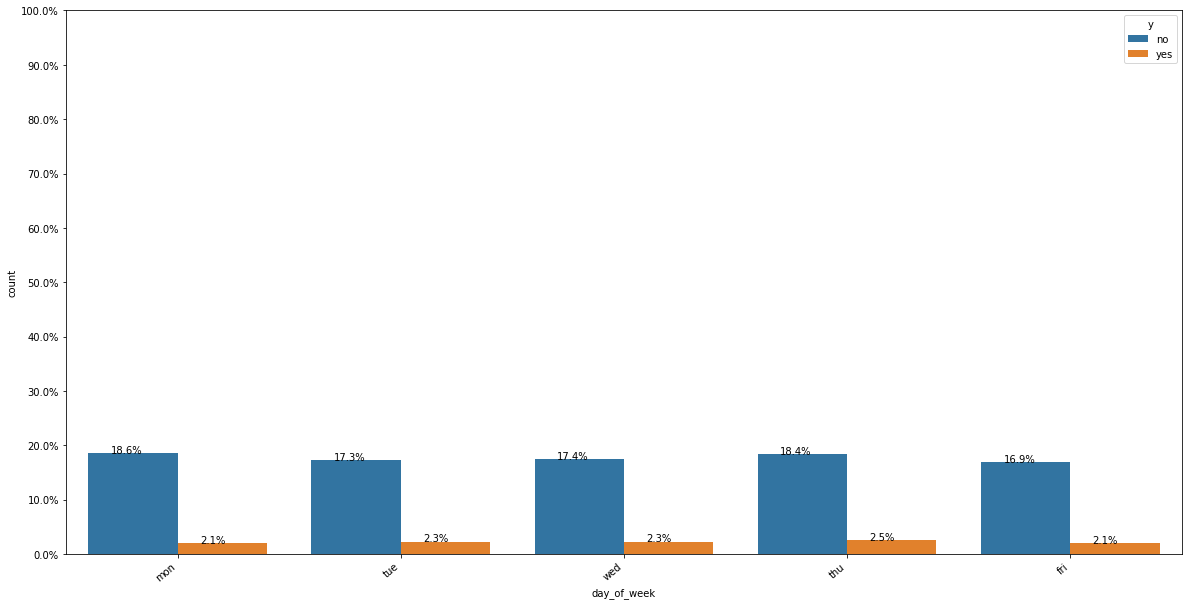

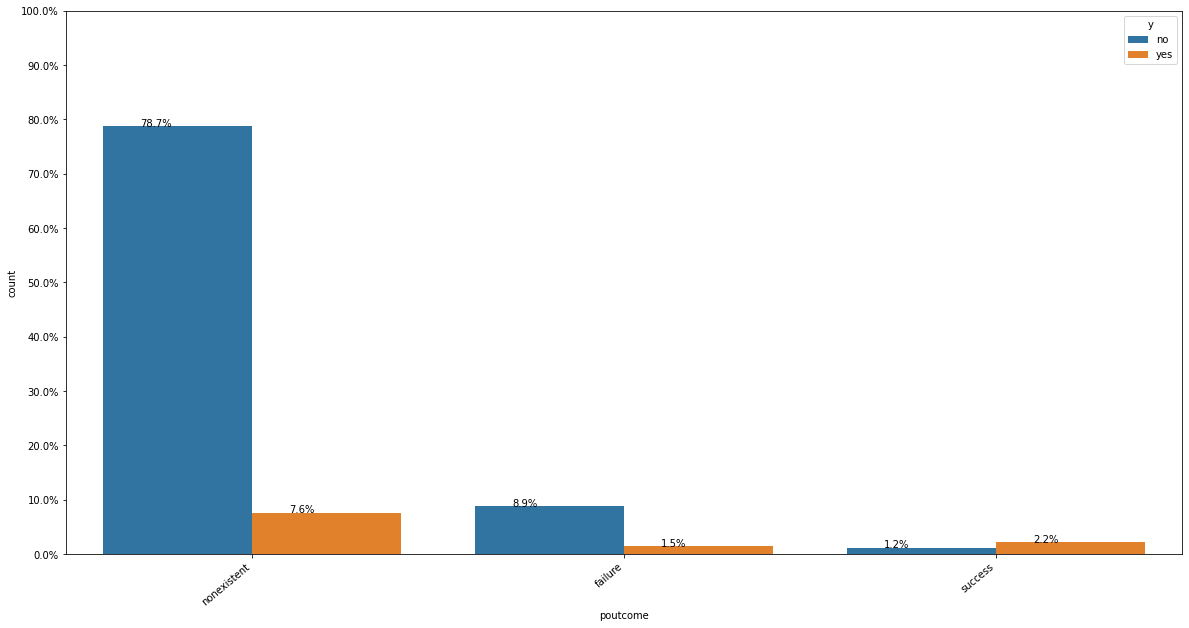

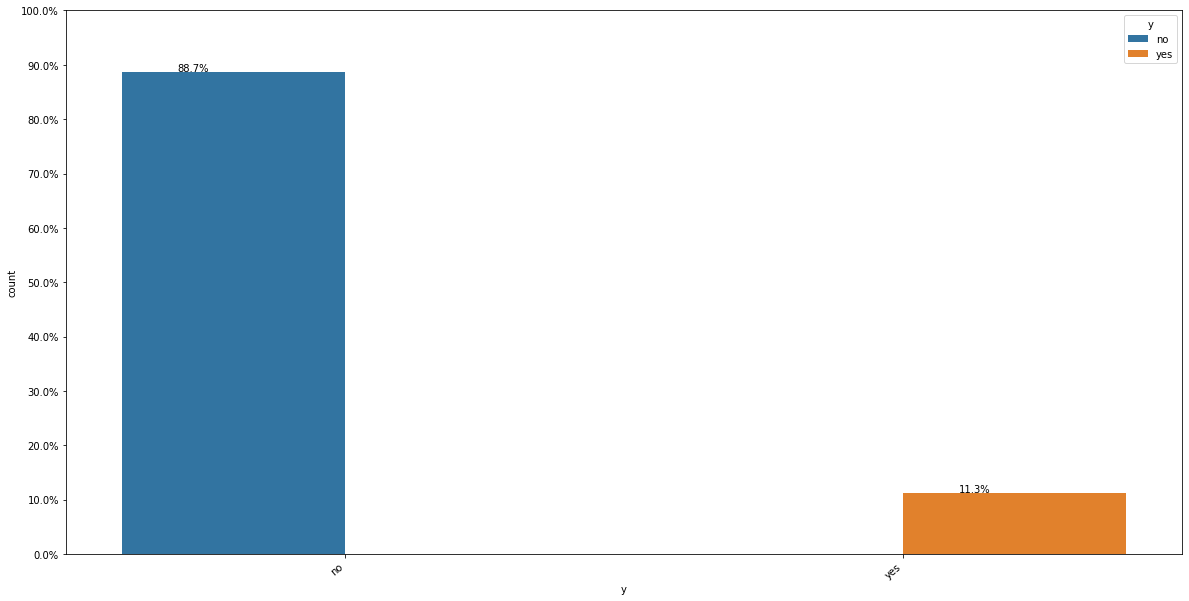

In [5]:
for label in categorical_columns:
  plt.figure(figsize=(20,10))
  Y = data['y']
  total = len(Y)*1.
  ax=sns.countplot(x=label, data=data, hue="y")
  for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))
  
  ax.yaxis.set_ticks(np.linspace(0, total, 11))
  ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
  
  plt.show()

In [6]:
# since the data is imbalanced (88.7% yes, and 11.3% no), and we dont want to lose any potential customers,
# thus we focus on attributes that affect the positive response more than negative response

# month affects negative responses more than positive responses (positive response is almost same for all months), so it can be dropped
# both negative and positive response is same for almost all day_of_week
# default seems important but then there is not much variation in default, almost all entries are 'no' and we will replace 'unknown' with 'no' later.
# education also does not affect positive responses much, but we can keep it
# job seems reasonable to keep

In [7]:
# conclusion: categorical columns to remove
#default
#month
#day_of_week

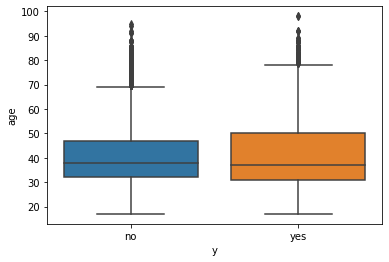

In [8]:
%matplotlib inline
sns.boxplot(data=data,x='y',y='age')
# the both labels 'yes' and 'no' have almost the same centre (median), thus age doesnt affect y much

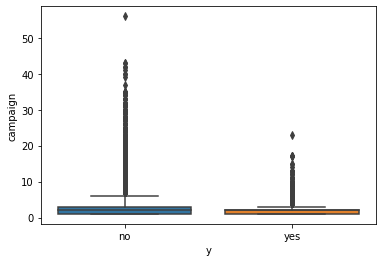

In [9]:
%matplotlib inline
sns.boxplot(data=data,x='y',y='campaign')

In [10]:
import statistics
max(data['campaign']), min(data['campaign']), statistics.variance(data['campaign']), statistics.median(data['campaign'])

(56, 1, 7.672975027862306, 2.0)

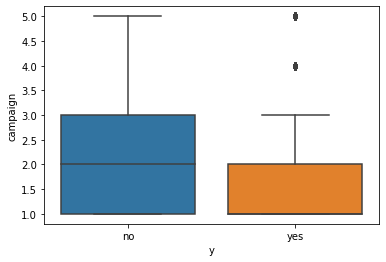

In [11]:
sns.boxplot(data=data[data['campaign']<6],x='y',y='campaign')
# seems like campaign affects y somehow

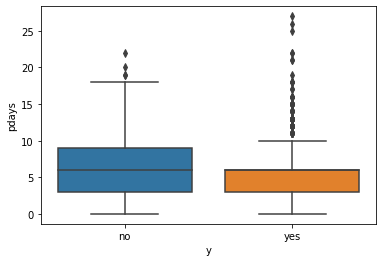

In [12]:
sns.boxplot(data=data[data['pdays']!=999],x='y',y='pdays')
# pdays also affects target variable

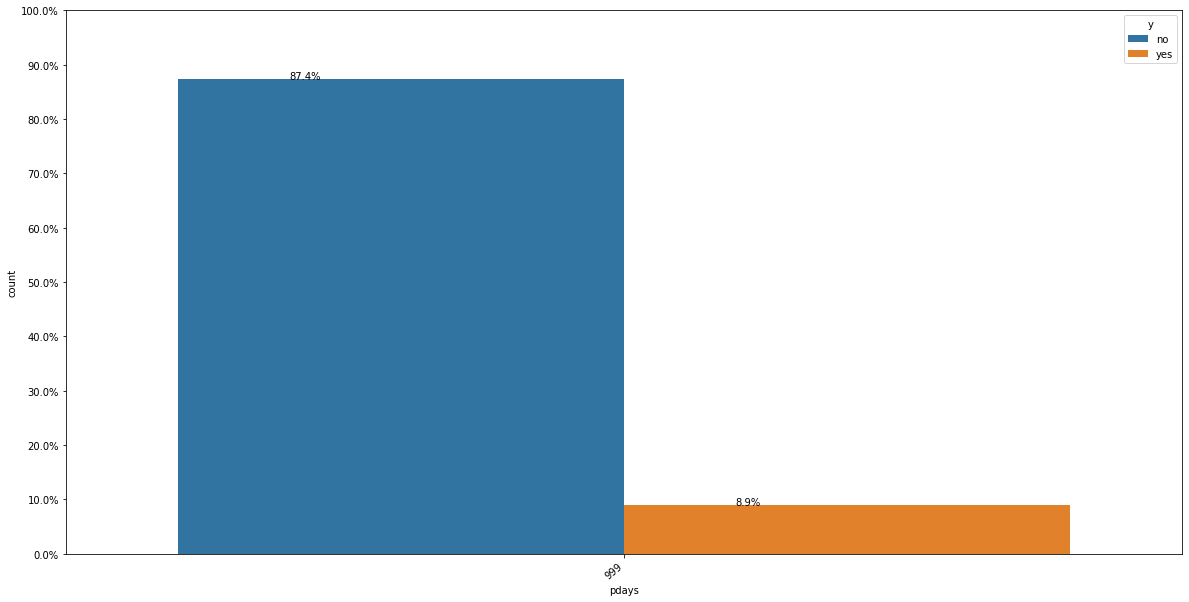

In [13]:
  plt.figure(figsize=(20,10))
  Y = data['y']
  total = len(Y)*1.
  ax=sns.countplot(x='pdays', data=data[data['pdays']==999], hue="y")
  for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

  ax.yaxis.set_ticks(np.linspace(0, total, 11))
  ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
  plt.show()

# 8.9% of clients who were not contacted before took the term deposit

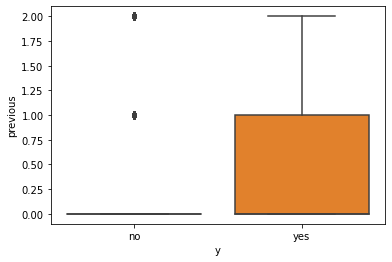

In [14]:
sns.boxplot(data=data[data['previous']<3],x='y',y='previous')
# took data=data[data['previous']<3] because outliers were compressing the boxplot making it unreadable

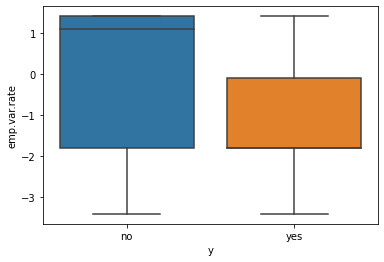

In [15]:
sns.boxplot(data=data,x='y',y='emp.var.rate')
# important

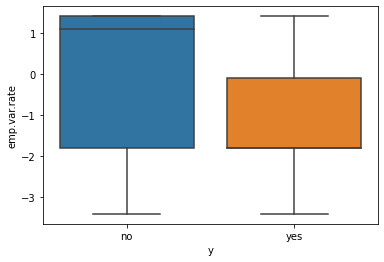

In [16]:
sns.boxplot(data=data,x='y',y='emp.var.rate')

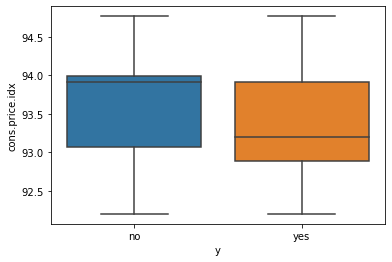

In [17]:
sns.boxplot(data=data,x='y',y='cons.price.idx')

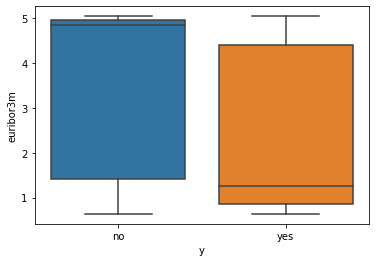

In [18]:
sns.boxplot(data=data,x='y',y='euribor3m')

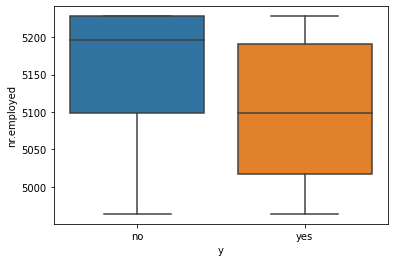

In [19]:
sns.boxplot(data=data,x='y',y='nr.employed')

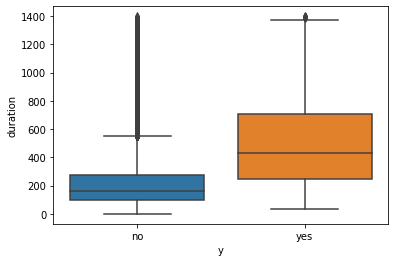

In [20]:
sns.boxplot(data=data[data['duration']<1400],x='y',y='duration')
# as written in metadata and visible from the boxplot, duration highly affects the class and is not always obtained for the test data
# thus removing it from test as well as train data

In [21]:
#conclusion: remove 
#age
#default
#month
#day_of_week
#duration

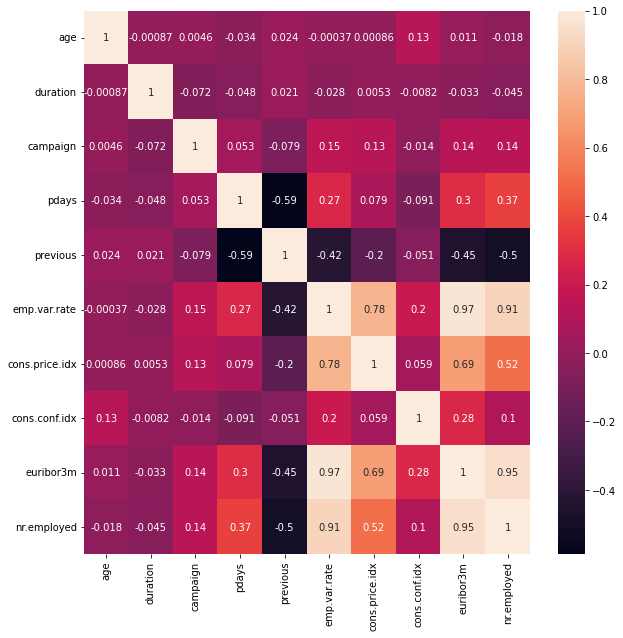

In [22]:
plt.figure(figsize=(10,10))
sns.heatmap(data.corr(), annot=True)

In [23]:
# delete duration column altogether
data.drop(['duration'], axis=1,inplace=True)
# not keeping 'duration' in test data because as given in the txt file, it may or may not be available

In [24]:
# cleaning the training data

In [25]:
# remove features based on the plots above
data.drop(['age','default','month','day_of_week'], axis=1,inplace=True)


# divide training data into yes and no class labels for further process
data_no = data[data['y']=='no']
data_yes = data[data['y']=='yes']


# 1) delete duplicates with class label = 'no'
data_no = data_no.drop_duplicates()

# 2) delete missing data rows with class label = 'no'
missing_rows = []
for i in data_no.index:
  if any(data_no.loc[i]=='unknown'):
    missing_rows.append(i)   # missing_rows = list of indices of rows with missing data
data_no.drop(index=missing_rows,inplace=True)

# 3) for rows with missing data and class label = 'yes', replace unknown with mode of column
cat_col = [col for col in data_yes.columns if data_yes[col].dtype=="O"]
for x in cat_col:
  data_yes[x] = data_yes[x].replace(['unknown'],data[x].mode()[0])

# not deleting duplicate rows with class label = 'yes' to stabilise the data with 'yes' as results.

In [26]:
data = pd.concat([data_no,data_yes])

In [27]:
# encode categorical variables in data
for x in (col for col in data.columns if data[col].dtype=="O"):
  enc= LabelEncoder()
  data[x]= enc.fit_transform(data[x])
  print(x,{labels:encoder for labels, encoder in enumerate(enc.classes_)})

job {0: 'admin.', 1: 'blue-collar', 2: 'entrepreneur', 3: 'housemaid', 4: 'management', 5: 'retired', 6: 'self-employed', 7: 'services', 8: 'student', 9: 'technician', 10: 'unemployed'}
marital {0: 'divorced', 1: 'married', 2: 'single'}
education {0: 'basic.4y', 1: 'basic.6y', 2: 'basic.9y', 3: 'high.school', 4: 'illiterate', 5: 'professional.course', 6: 'university.degree'}
housing {0: 'no', 1: 'yes'}
loan {0: 'no', 1: 'yes'}
contact {0: 'cellular', 1: 'telephone'}
poutcome {0: 'failure', 1: 'nonexistent', 2: 'success'}
y {0: 'no', 1: 'yes'}


In [28]:
# divide into test and train
x= data.iloc[:, :-1]
y= data.iloc[:, -1:]

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, shuffle=True, random_state=1)

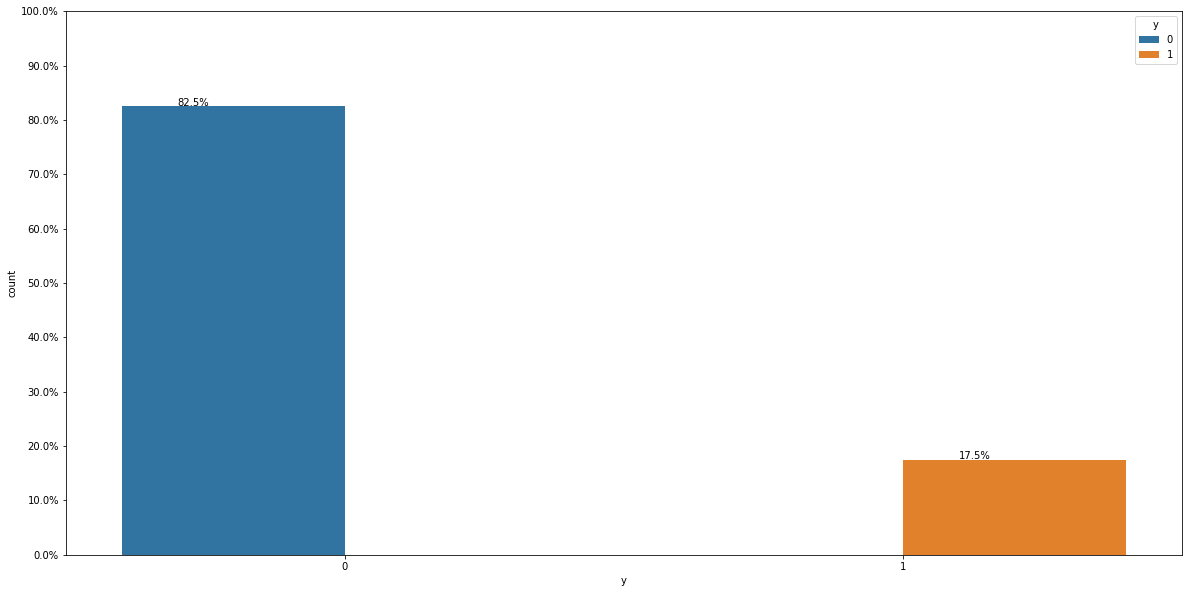

In [29]:
  plt.figure(figsize=(20,10))
  Y = y_train
  total = len(Y)*1.
  ax=sns.countplot(x='y', data=y_train, hue="y")
  for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))
  
  ax.yaxis.set_ticks(np.linspace(0, total, 11))
  ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
  ax.set_xticklabels(ax.get_xticklabels())
  
  plt.show()

In [30]:
# Random Forest

In [31]:
'''param_grid= {'n_estimators':[500], 'min_samples_split': [5,10,15,20], 'max_depth':[4,5,6,10,15,20]}

grid = GridSearchCV(RandomForestClassifier(), param_grid, refit = True, verbose = 0,scoring='recall')
grid.fit(x_train, y_train) 
 
# print best parameter after tuning 
print(grid.best_params_)'''

"param_grid= {'n_estimators':[500], 'min_samples_split': [5,10,15,20], 'max_depth':[4,5,6,10,15,20]}\n\ngrid = GridSearchCV(RandomForestClassifier(), param_grid, refit = True, verbose = 0,scoring='recall')\ngrid.fit(x_train, y_train) \n \n# print best parameter after tuning \nprint(grid.best_params_)"

In [32]:
# {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 500} = output of above cell

In [33]:
'''param_grid= {'n_estimators':[200], 'min_samples_split': [5,10,15,20], 'max_depth':[4,5,6,10,15,20]}

grid = GridSearchCV(RandomForestClassifier(), param_grid, refit = True, verbose = 0,scoring='recall')
grid.fit(x_train, y_train) 
 
# print best parameter after tuning 
print(grid.best_params_)'''

"param_grid= {'n_estimators':[200], 'min_samples_split': [5,10,15,20], 'max_depth':[4,5,6,10,15,20]}\n\ngrid = GridSearchCV(RandomForestClassifier(), param_grid, refit = True, verbose = 0,scoring='recall')\ngrid.fit(x_train, y_train) \n \n# print best parameter after tuning \nprint(grid.best_params_)"

In [34]:
#{'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200} = output of above cell

In [35]:
start= time.time()

rf= RandomForestClassifier(n_estimators=500, criterion='gini', max_depth=20,bootstrap=True, min_samples_split= 5, min_impurity_split=0.1,
                           oob_score=True, random_state=1)
model1= rf.fit(x_train, y_train)
pred_train= model1.predict(x_train)

end = time.time()
print(f"Runtime of the program is {end - start}")

print()

print('TRAIN')
print(classification_report(y_train,pred_train))
print('recall= ',recall_score(y_train,pred_train))
print()
predictions= model1.predict(x_test)
print('TEST')
print(classification_report(y_test,predictions))
print('recall= ',recall_score(y_test,predictions))
print('f1_score= ',f1_score(y_test,predictions))

Runtime of the program is 11.365137100219727

TRAIN
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     17698
           1       0.93      0.55      0.69      3758

    accuracy                           0.91     21456
   macro avg       0.92      0.77      0.82     21456
weighted avg       0.91      0.91      0.90     21456

recall=  0.5486961149547632

TEST
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      4482
           1       0.59      0.32      0.42       882

    accuracy                           0.85      5364
   macro avg       0.74      0.64      0.67      5364
weighted avg       0.83      0.85      0.83      5364

recall=  0.3219954648526077
f1_score=  0.41734019103600295


In [36]:
model1.oob_score_  #Sort of validation score
#So model generalises well

0.8428877703206562

In [37]:
#Feature Importance
model1.feature_importances_

array([0.10728324, 0.04984735, 0.08053876, 0.03049516, 0.02339994,
       0.02659081, 0.08755723, 0.05728814, 0.02591059, 0.04816723,
       0.04105279, 0.04203633, 0.05139899, 0.24087289, 0.08756054])

In [38]:
feature_names = [x for x in x_train.columns]
len(feature_names)

15

Text(0.5, 1.0, 'Feature importances')

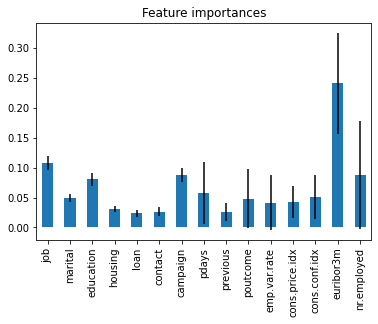

In [39]:
std = np.std([
    tree.feature_importances_ for tree in model1.estimators_], axis=0)


forest_importances = pd.Series(model1.feature_importances_, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")


In [40]:
# Data frame of feature importance
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = x.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

feature_importances


,importance
euribor3m,0.240873
job,0.107283
nr.employed,0.087561
campaign,0.087557
education,0.080539
pdays,0.057288
cons.conf.idx,0.051399
marital,0.049847
poutcome,0.048167
cons.price.idx,0.042036


In [41]:
# Decision Tree 

In [42]:
'''param_grid= { 'min_samples_split': [5,10,15,20], 'max_depth':[2,3,4,5,6,7,8],'min_impurity_split':[0.1,0.2,0.3,0.4],'random_state':[1]}

grid = GridSearchCV(tree.DecisionTreeClassifier(), param_grid, refit = True, verbose = 0,scoring='recall')
grid.fit(x_train, y_train) 
 
# print best parameter after tuning 
print(grid.best_params_)'''

"param_grid= { 'min_samples_split': [5,10,15,20], 'max_depth':[2,3,4,5,6,7,8],'min_impurity_split':[0.1,0.2,0.3,0.4],'random_state':[1]}\n\ngrid = GridSearchCV(tree.DecisionTreeClassifier(), param_grid, refit = True, verbose = 0,scoring='recall')\ngrid.fit(x_train, y_train) \n \n# print best parameter after tuning \nprint(grid.best_params_)"

In [43]:
# {'max_depth': 8, 'min_impurity_split': 0.1, 'min_samples_split': 10, 'random_state': 1} = output of above cell

In [44]:
start= time.time()

dtc = tree.DecisionTreeClassifier(max_depth=8,min_samples_split=10,min_impurity_split=0.1, random_state=1)
model2 = dtc.fit(x_train, y_train)
predictions= model2.predict(x_test)
pred_train=model2.predict(x_train)

end = time.time()
print(f"Runtime of the program is {end - start}")

print()

print('TRAIN')
print(classification_report(y_train,pred_train))
print('recall= ',recall_score(y_train,pred_train))
print()
print('TEST')
print(classification_report(y_test,predictions))
print('recall= ',recall_score(y_test,predictions))
print('f1_score= ',f1_score(y_test,predictions))
# support is number of occurence of each label in y_test

Runtime of the program is 0.06331276893615723

TRAIN
              precision    recall  f1-score   support

           0       0.88      0.96      0.92     17698
           1       0.69      0.37      0.48      3758

    accuracy                           0.86     21456
   macro avg       0.78      0.67      0.70     21456
weighted avg       0.85      0.86      0.84     21456

recall=  0.36961149547631716

TEST
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      4482
           1       0.60      0.33      0.43       882

    accuracy                           0.85      5364
   macro avg       0.74      0.65      0.67      5364
weighted avg       0.83      0.85      0.84      5364

recall=  0.3344671201814059
f1_score=  0.43065693430656937


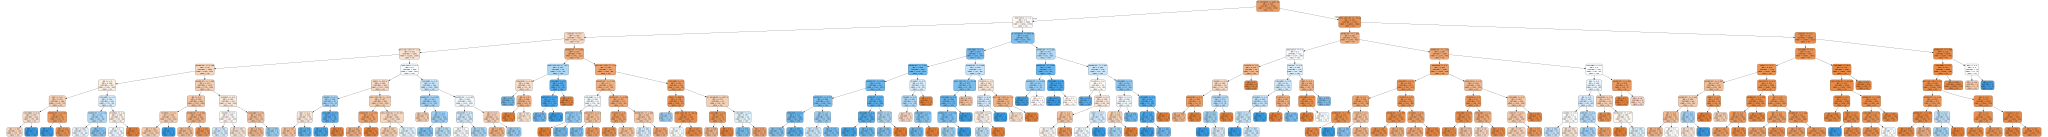

<Figure size 720x720 with 0 Axes>

In [45]:
plt.figure(figsize=(10,10))

import graphviz
from sklearn.tree import export_graphviz
dot_data = export_graphviz(dtc, out_file=None, filled=True, rounded=True,
                                feature_names=list(x_train.columns),  
                                class_names=['no','yes'])
graph = graphviz.Source(dot_data)  
graph


In [46]:
# Naive Bayes

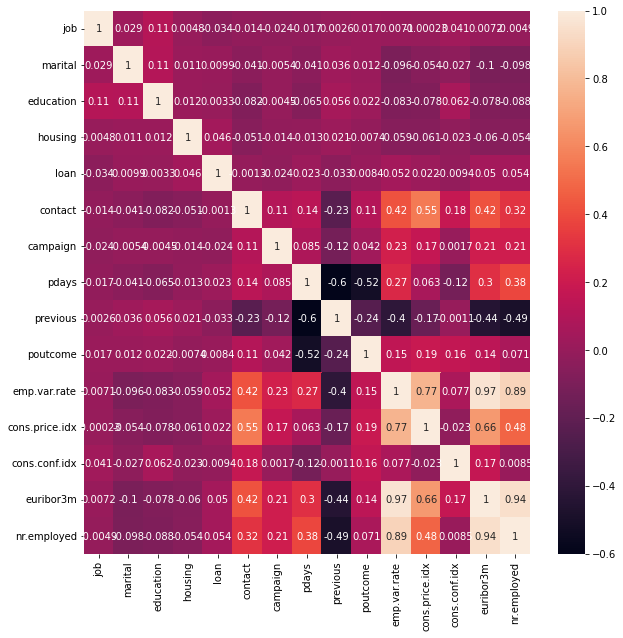

In [47]:
plt.figure(figsize=(10,10))
sns.heatmap(x_train.corr(), annot=True)

In [48]:
# GaussianNB before removing correlated features
start = time.time()

clf = GaussianNB()
model3= clf.fit(x_train,y_train)
predictions= model3.predict(x_test)
pred_train=model3.predict(x_train)

end = time.time()

print(f"Runtime of the program is {end - start}")


print()

print('TRAIN')
print(classification_report(y_train,pred_train))
print('recall= ',recall_score(y_train,pred_train))
print()
print('TEST')
print(classification_report(y_test,predictions))
print('recall= ',recall_score(y_test,predictions))
print('f1_score= ',f1_score(y_test,predictions))
# support is number of occurence of each label in y_test

Runtime of the program is 0.03234386444091797

TRAIN
              precision    recall  f1-score   support

           0       0.88      0.84      0.86     17698
           1       0.39      0.48      0.43      3758

    accuracy                           0.78     21456
   macro avg       0.64      0.66      0.65     21456
weighted avg       0.80      0.78      0.79     21456

recall=  0.48217136774880254

TEST
              precision    recall  f1-score   support

           0       0.90      0.85      0.87      4482
           1       0.39      0.51      0.44       882

    accuracy                           0.79      5364
   macro avg       0.65      0.68      0.66      5364
weighted avg       0.81      0.79      0.80      5364

recall=  0.5079365079365079
f1_score=  0.4433448787728847


In [49]:
# we read somewhere that NB can be applied in mixed data in two ways:
# 1) convert all continuous columns to categorical
# 2) mixed model containing both GaussianNB() and CategoricalNB()
# we try to attempt the 1) solution.

In [50]:
# encodin numerical variables in x_train and x_test to apply categorical NB
for x in (col for col in x_train.columns if x_train[col].dtype!="O"):
  enc= LabelEncoder()
  x_train[x]= enc.fit_transform(x_train[x])

for x in (col for col in x_test.columns if x_test[col].dtype!="O"):
  enc= LabelEncoder()
  x_test[x]= enc.fit_transform(x_test[x])

# CategoricalNB before removing correlated features
start = time.time()

clf = CategoricalNB()
model3= clf.fit(x_train,y_train)
predictions= model3.predict(x_test)
pred_train=model3.predict(x_train)

end = time.time()

print(f"Runtime of the program is {end - start}")


print()

print('TRAIN')
print(classification_report(y_train,pred_train))
print('recall= ',recall_score(y_train,pred_train))
print()
print('TEST')
print(classification_report(y_test,predictions))
print('recall= ',recall_score(y_test,predictions))
print('f1_score= ',f1_score(y_test,predictions))
# support is number of occurence of each label in y_test

Runtime of the program is 0.027425527572631836

TRAIN
              precision    recall  f1-score   support

           0       0.91      0.86      0.88     17698
           1       0.47      0.57      0.52      3758

    accuracy                           0.81     21456
   macro avg       0.69      0.72      0.70     21456
weighted avg       0.83      0.81      0.82     21456

recall=  0.5739755188930282

TEST
              precision    recall  f1-score   support

           0       0.93      0.60      0.73      4482
           1       0.27      0.76      0.40       882

    accuracy                           0.62      5364
   macro avg       0.60      0.68      0.56      5364
weighted avg       0.82      0.62      0.67      5364

recall=  0.7619047619047619
f1_score=  0.4


In [51]:
x_train.drop(data[['cons.price.idx', 'emp.var.rate', 'nr.employed']], axis=1, inplace=True)
x_test.drop(data[['cons.price.idx', 'emp.var.rate', 'nr.employed']], axis=1, inplace=True)

In [52]:
# GaussianNB after removing correlated features
start = time.time()

clf = GaussianNB()
model3= clf.fit(x_train,y_train)
predictions= model3.predict(x_test)
pred_train=model3.predict(x_train)

end = time.time()
print(f"Runtime of the program is {end - start}")
print()
print('TRAIN')
print(classification_report(y_train,pred_train))
print('recall= ',recall_score(y_train,pred_train))
print()
print('TEST')
print(classification_report(y_test,predictions))
print('recall= ',recall_score(y_test,predictions))
print('f1_score= ',f1_score(y_test,predictions))
# support is number of occurence of each label in y_test

Runtime of the program is 0.018171310424804688

TRAIN
              precision    recall  f1-score   support

           0       0.87      0.92      0.90     17698
           1       0.50      0.37      0.43      3758

    accuracy                           0.82     21456
   macro avg       0.69      0.65      0.66     21456
weighted avg       0.81      0.82      0.81     21456

recall=  0.3704097924427887

TEST
              precision    recall  f1-score   support

           0       0.89      0.83      0.86      4482
           1       0.36      0.48      0.41       882

    accuracy                           0.77      5364
   macro avg       0.63      0.66      0.64      5364
weighted avg       0.80      0.77      0.79      5364

recall=  0.48299319727891155
f1_score=  0.41239109390125844


In [53]:
# encodin numerical variables in x_train and x_test to apply categorical NB
for x in (col for col in x_train.columns if x_train[col].dtype!="O"):
  enc= LabelEncoder()
  x_train[x]= enc.fit_transform(x_train[x])

for x in (col for col in x_test.columns if x_test[col].dtype!="O"):
  enc= LabelEncoder()
  x_test[x]= enc.fit_transform(x_test[x])

In [54]:
# CategoricalNB after removing correlated features
start = time.time()

clf = CategoricalNB()
model3= clf.fit(x_train,y_train)
predictions= model3.predict(x_test)
pred_train=model3.predict(x_train)

end = time.time()

print(f"Runtime of the program is {end - start}")


print()

print('TRAIN')
print(classification_report(y_train,pred_train))
print('recall= ',recall_score(y_train,pred_train))
print()
print('TEST')
print(classification_report(y_test,predictions))
print('recall= ',recall_score(y_test,predictions))
print('f1_score= ',f1_score(y_test,predictions))
# support is number of occurence of each label in y_test

Runtime of the program is 0.023994922637939453

TRAIN
              precision    recall  f1-score   support

           0       0.90      0.89      0.89     17698
           1       0.50      0.54      0.52      3758

    accuracy                           0.83     21456
   macro avg       0.70      0.71      0.71     21456
weighted avg       0.83      0.83      0.83     21456

recall=  0.538850452368281

TEST
              precision    recall  f1-score   support

           0       0.94      0.28      0.43      4482
           1       0.20      0.91      0.33       882

    accuracy                           0.38      5364
   macro avg       0.57      0.60      0.38      5364
weighted avg       0.82      0.38      0.41      5364

recall=  0.9149659863945578
f1_score=  0.3283157038242473
